In [51]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import pylab
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score
import pickle

In [2]:
root = os.getcwd()
data_root = os.path.join(root, 'data')

In [3]:
train_data = pd.read_csv(os.path.join(data_root, 'training_v2.csv.zip'))

In [4]:
dictionary = pd.read_csv(os.path.join(data_root, 'WiDS Datathon 2020 Dictionary.csv'))

In [5]:
train_data.shape

(91713, 186)

In [6]:
train_data['hospital_death'].value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

# Feature Engineering

1. Create a Missing value dummy for each column with missing values

In [7]:
missing_val_col = list(pd.DataFrame(train_data.isnull().sum().sort_values(ascending=False))\
.reset_index()\
.rename(columns={0: 'nan_count', 'index': 'features'})\
.query('nan_count > 0')['features'])

In [8]:
'missing_' + missing_val_col[0]

'missing_h1_bilirubin_min'

In [9]:
train_data.shape

(91713, 186)

In [10]:
for col in missing_val_col:
    missing_col_name = 'missing_' + col
    train_data[missing_col_name] = pd.isnull(train_data[col]).astype(int)

2. Replace missing value with mean for int/float columns and with most popular value for str columns

In [11]:

for col in missing_val_col:
    if train_data[col].dtype == 'O':
        popular_val = train_data[col].value_counts().index[0]
        train_data[col].fillna(popular_val, inplace=True)
    else:
        mean_val = train_data[col].mean()
        train_data[col].fillna(mean_val, inplace=True)

3. Upsample the death case

In [12]:
train_data.columns

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       ...
       'missing_d1_mbp_min', 'missing_d1_mbp_max', 'missing_d1_diasbp_min',
       'missing_d1_diasbp_max', 'missing_d1_sysbp_min', 'missing_d1_sysbp_max',
       'missing_d1_heartrate_max', 'missing_d1_heartrate_min',
       'missing_icu_admit_source', 'missing_gender'],
      dtype='object', length=361)

In [19]:
wrong_df = train_data.loc[train_data['hospital_death'] == 1]
up_sample_size = 25000                                      

In [21]:
wrong_df = wrong_df.sample(up_sample_size, replace=True)

In [25]:
upsampled_df = pd.concat([train_data, wrong_df], ignore_index=True)

In [26]:
upsampled_df.shape

(116713, 361)

# Train Test Prep

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score

In [28]:
y = upsampled_df[['hospital_death']]
X = upsampled_df.drop('hospital_death', axis=1)

In [29]:
string_col = list(X.select_dtypes(include='O').columns)

In [30]:
string_col

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [31]:
X_dummies = pd.get_dummies(X[string_col])
X.drop(string_col, axis=1, inplace=True)

In [32]:
X.select_dtypes(include='O').columns

Index([], dtype='object')

In [33]:
X =pd.concat([X, X_dummies], axis=1)

In [40]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 0)
                                        

In [47]:
test_y['hospital_death'].value_counts()

0    16716
1     6627
Name: hospital_death, dtype: int64

In [48]:
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(train_X)
# Apply transform to both the training set and the test set.
train_X = scaler.transform(train_X)
test_X= scaler.transform(test_X)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [49]:
train_X

array([[ 0.77706884, -1.02623897, -0.26370443, ..., -0.20378801,
        -0.05705891, -0.18868856],
       [-0.08515447, -0.42069698,  1.56209166, ..., -0.20378801,
        -0.05705891, -0.18868856],
       [ 1.19835309,  0.60843615, -0.12081604, ..., -0.20378801,
        -0.05705891, -0.18868856],
       ...,
       [-1.38385224, -1.43777057,  1.27631488, ..., -0.20378801,
        -0.05705891, -0.18868856],
       [ 1.40369844, -1.6051495 , -0.08906307, ..., -0.20378801,
        -0.05705891,  5.29973843],
       [ 0.14935611,  0.52322602, -0.21607497, ..., -0.20378801,
        -0.05705891, -0.18868856]])

In [52]:
pickle.dump(train_X, open(os.path.join(data_root, 'train_X.pickle'), "wb"))
pickle.dump(test_X, open(os.path.join(data_root, 'test_X.pickle'), "wb"))
pickle.dump(train_y, open(os.path.join(data_root, 'train_y.pickle'), "wb"))
pickle.dump(test_y, open(os.path.join(data_root, 'test_y.pickle'), "wb"))

# Log Reg for non-PCA

In [53]:
from sklearn.linear_model import LogisticRegression
LogReg_nonPCA = LogisticRegression(solver = 'lbfgs')

In [54]:
LogReg_nonPCA.fit(train_X, train_y)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [55]:
y_pred_class_nonPCA = LogReg_nonPCA.predict(test_X)
y_pred_score_nonPCA = LogReg_nonPCA.predict_proba(test_X)

In [56]:
#Accuracy
print('Accuracy is {}'.format(LogReg_nonPCA.score(test_X, test_y)))
# AUC
print('AUC score is {}'.format(roc_auc_score(test_y, y_pred_score_nonPCA[:, 1])))


Accuracy is 0.8357537591569207
AUC score is 0.8921686691954964


In [66]:
print('Death rate is: {}'
      .format(upsampled_df.loc[upsampled_df['hospital_death'] == 1].shape[0] 
              / upsampled_df.shape[0]))

Death rate is: 0.2820165705619768


# PCA

In [351]:
# Make an instance of the Model
pca = PCA(.95) #
pca.fit(train_X)
train_X_pca = pca.transform(train_X)
test_X_pca = pca.transform(test_X)

In [359]:
pca.n_components_

160

# Logistic Regression Model

In [360]:
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression(solver = 'lbfgs')

In [361]:
LogReg.fit(train_X_pca, train_y)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [366]:
y_pred_class = LogReg.predict(test_X_pca)
y_pred_score = LogReg.predict_proba(test_X_pca)

In [373]:
y_pred_score[:, 1].shape

(18343,)

In [371]:
test_y.shape

(18343, 1)

In [378]:
#Accuracy
print('Accuracy is {}'.format(LogReg.score(test_X_pca, test_y)))
# AUC
print('AUC score is {}'.format(roc_auc_score(test_y, y_pred_score[:, 1])))


Accuracy is 0.9249304911955515
AUC score is 0.8850739038193595


# Graphical Analysis

(array([ 2271.,  2981.,  3538.,  5314.,  8002., 11824., 15944., 14264.,
        12670., 10677.]),
 array([16. , 23.3, 30.6, 37.9, 45.2, 52.5, 59.8, 67.1, 74.4, 81.7, 89. ]),
 <a list of 10 Patch objects>)

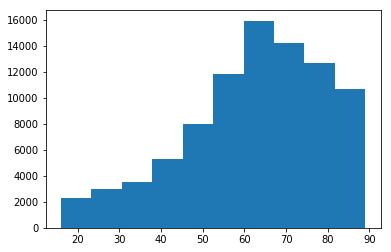

In [12]:
pylab.hist(train_data[~np.isnan(train_data['age'])]['age'])

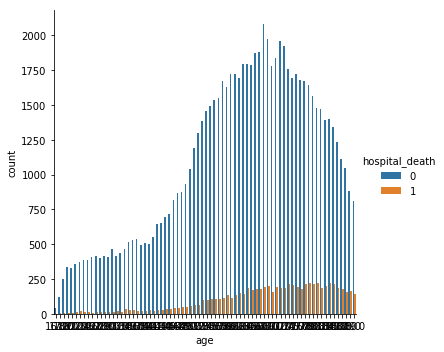

In [14]:
# age
sns.catplot(data=train_data, kind='count', x='age', hue='hospital_death')

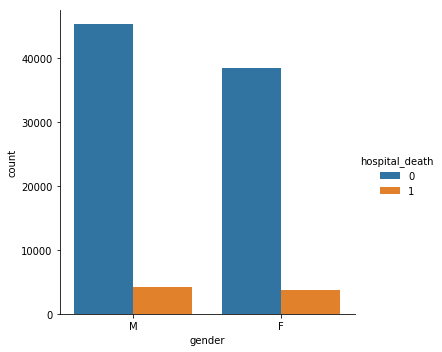

In [16]:
# gender
sns.catplot(data=train_data, kind='count', x='gender', hue='hospital_death')

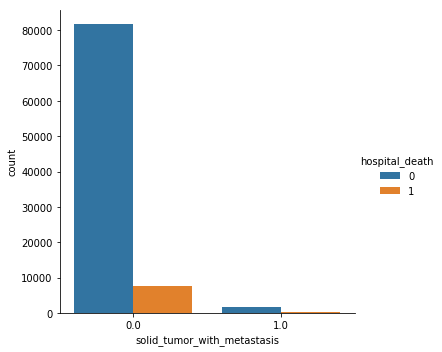

In [19]:
# solid_tumor_with_metastasis
sns.catplot(data=train_data, kind='count', x='solid_tumor_with_metastasis', hue='hospital_death')

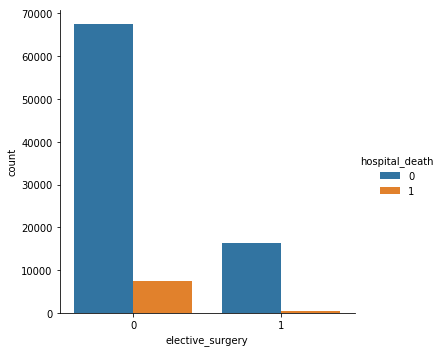

In [26]:
# elective_surgery
sns.catplot(data=train_data, kind='count', x='elective_surgery', hue='hospital_death')